# Image Classification on oxford_flowers102 dataset (84% - accuracy)
## Steps
- import modules
- download dataset
- explore the dataset
- create the dataset pipeline 
- build  mobilenet_v2 feature extractor 
- build data augmentation
- build classification head
- build the final model 
- compile the final model 
- write callbacks 
- train the final model 
- plot the training curve
- load and evaluate the final model 
- export the model





In [8]:
## necessary imports 
import json
import tensorflow as tf 
import tensorflow_datasets as tfds 
from tensorflow import keras 
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
from PIL import Image
import pickle

In [ ]:
IMG_RES = 224
BATCH_SIZE = 32

## Build and explore the datasets

In [2]:
## load the data 
(training_data, test_data , validation_data), data_infos = tfds.load('oxford_flowers102',split=['test', 'train','validation'],
                                                shuffle_files=True,
                                                as_supervised= True,
                                                with_info=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteUIDLM8/oxford_flowers102-train.tfrecord*…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteUIDLM8/oxford_flowers102-test.tfrecord*.…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteUIDLM8/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
## explore the dataset

In [5]:
print("Total number of training samples :", len(training_data))
print("Total number of test samples :", len(test_data))
print("Total number of validation samples :", len(validation_data))

num_classes = data_infos.features['label'].num_classes
print("Total number of classes  :", num_classes)


Total number of training samples : 6149
Total number of test samples : 1020
Total number of validation samples : 1020
Total number of classes  : 102


In [ ]:
for i , sample in enumerate(training_data.take(3)):
  print("Image {} shape {} label {}".format(i+1, sample[0].shape, sample[1]))

Image 1 shape (542, 500, 3) label 40
Image 2 shape (748, 500, 3) label 76
Image 3 shape (500, 600, 3) label 42


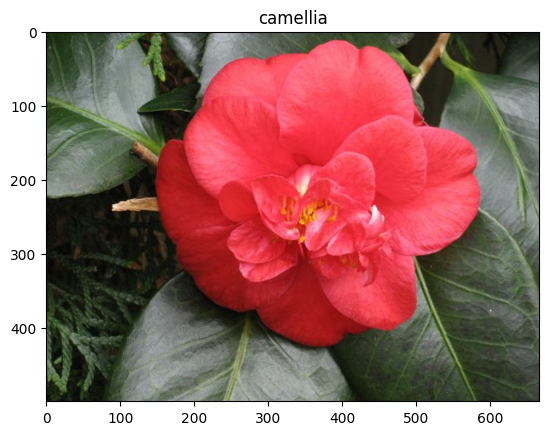

In [6]:
get_label_name = data_infos.features['label'].int2str 

for image, label in training_data.take(1):
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.show()

In [ ]:
## create pipeline
def normalize_img(image, label, img_size=IMG_RES):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (img_size, img_size))
    return tf.cast(image, tf.float32) / 255., label 

def build_dataset(dataset, infos = data_infos, which='train', batch_size = BATCH_SIZE):
    dataset = dataset.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)
    if which == 'test':
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(1)
        return dataset
    dataset = dataset.cache()
    if which == 'train':
      dataset = dataset.shuffle(len(training_data)//4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
train_ds = build_dataset(training_data, which='train')
validation_ds = build_dataset(validation_data, which='validation')
test_ds = build_dataset(test_data, which='test')

## Build the model

In [ ]:
## build and train the classifier

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_RES, IMG_RES, 3))

feature_extractor.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])


In [ ]:
## classification head 

classifier = keras.Sequential([
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
], name="head_classifier")

In [ ]:
inputs = keras.Input(shape=(IMG_RES, IMG_RES, 3))
x = data_augmentation(inputs)
x = feature_extractor(x, training=False)
outputs = classifier(x)

model = keras.Model(inputs , outputs , name="mobilenet_v2_keras")

In [ ]:
base_learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate= base_learning_rate)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer = optimizer,
              loss= loss , 
              metrics = ["accuracy"]    
)

model.summary()

Model: "mobilenet_v2_keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 head_classifier (Sequential  (None, 102)              1416294   
 )                                                               
                                                                 
Total params: 3,674,278
Trainable params: 1,416,294
Non-trainable params: 2,257,984
_________________________________________________________________


## Compile and Train the model

In [ ]:
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath = "{}.keras".format(model.name),
    save_best_only = True
)

EarlyStopping = keras.callbacks.EarlyStopping(
    patience = 5,
    restore_best_weights = True
)

In [ ]:
initial_epoch = 20
loss0 , accuracy0 = model.evaluate(validation_ds)

print("Initial Loss : {}".format(loss0))   
print("Initial Accuracy : {}".format(accuracy0))

32/32 [==============================] - 16s 135ms/step - loss: 4.8515 - accuracy: 0.0049
Initial Loss : 4.851524353027344
Initial Accuracy : 0.0049019609577953815


In [ ]:
tf.keras.backend.clear_session()
history = model.fit( train_ds,
                    validation_data = validation_ds ,
                    epochs = initial_epoch+20 ,
                    callbacks = [ModelCheckpoint, EarlyStopping])

Epoch 1/40
193/193 [==============================] - 26s 89ms/step - loss: 3.6528 - accuracy: 0.2257 - val_loss: 3.2329 - val_accuracy: 0.2686
Epoch 2/40
193/193 [==============================] - 11s 57ms/step - loss: 2.1719 - accuracy: 0.5025 - val_loss: 2.1622 - val_accuracy: 0.4843
Epoch 3/40
193/193 [==============================] - 11s 57ms/step - loss: 1.5568 - accuracy: 0.6225 - val_loss: 1.6000 - val_accuracy: 0.6500
Epoch 4/40
193/193 [==============================] - 11s 57ms/step - loss: 1.2359 - accuracy: 0.6943 - val_loss: 1.2993 - val_accuracy: 0.7078
Epoch 5/40
193/193 [==============================] - 11s 56ms/step - loss: 1.0541 - accuracy: 0.7325 - val_loss: 1.1541 - val_accuracy: 0.7324
Epoch 6/40
193/193 [==============================] - 11s 57ms/step - loss: 0.9304 - accuracy: 0.7546 - val_loss: 1.0151 - val_accuracy: 0.7588
Epoch 7/40
193/193 [==============================] - 11s 57ms/step - loss: 0.8204 - accuracy: 0.7865 - val_loss: 0.9061 - val_accuracy:

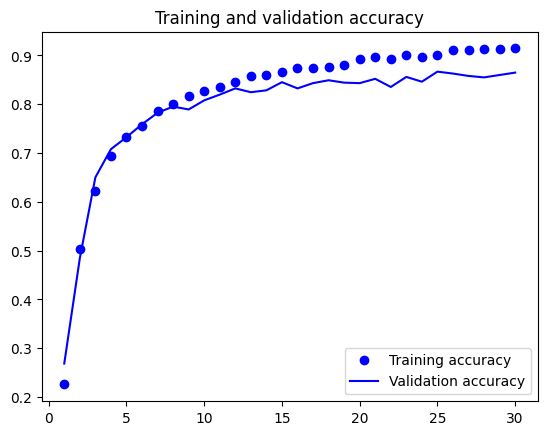

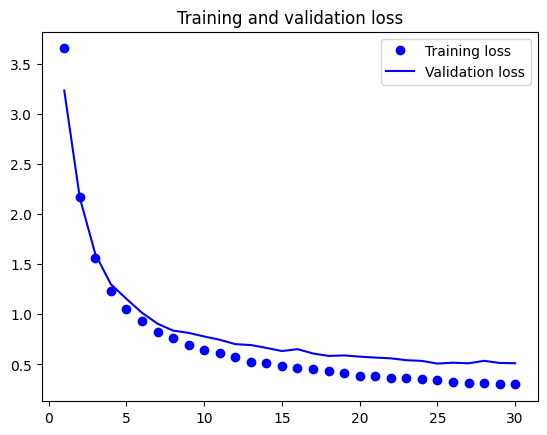

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# load the best saved model and evaluate it on the test dataset
path = "{}.keras".format(model.name)
model = keras.models.load_model(path,  custom_objects={'KerasLayer': hub.KerasLayer})
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 61ms/step - loss: 0.5714 - accuracy: 0.8373
Test accuracy: 0.837


## export the model


In [3]:
config_path = "model_config.json"
weights_path = "model_weights.h5"
label_name_path = "label_name_dict.pickle"

In [7]:
## get a dictionary of the labels 
label_name_dict = {}
for i in range(102):
  label_name_dict[i] = get_label_name(i)

label_name_dict[0]

'pink primrose'

In [9]:
# Serialize the dictionary using pickle
with open(label_name_path, 'wb') as f:
    pickle.dump(label_name_dict, f)

In [ ]:
## get the model's config in ajson file and write it to disk

model_config = model.to_json()
with open(config_path,"w") as file :
  file.write(model_config)


In [ ]:
## export the weights 

model.save_weights(save_format="h5", filepath=weights_path)

In [ ]:
## download the model config, weights and labels dictionary 
from google.colab import files
files.download(config_path)
files.download(weights_path)
files.download(label_name_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>